## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution
3. Surface plots

In [1]:
import sys
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
# from nilearn import datasets, surface, plotting
from pathlib import Path

In [2]:
dataset = "qpn"
current_release = "Oct_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# mri_info
mri_sessions_csv = f"{tabular_dir}/mri_info/mri_sessions.csv"

# imaging derivatives
FS_dir = f"{dataset_dir}/derivatives/freesurfer/v{FS_version}"
FS_DKT_dir = f"{FS_dir}/IDP/{session}/"
DKT_csv = f"{FS_DKT_dir}/dkt.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg.csv"

# UKB encoding of FS fields (DKT + asg) and FS6 vs 7 ROI naming maps
region_field_dir = "/home/nikhil/projects/Parkinsons/region_field_ids/"
ukbb_dkt_ct_fields = f"{region_field_dir}/FS_DKT_UKBB_Fields_ROI_map.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/FS_ASEG_UKBB_Fields_ROI_map.csv"

# save dirs
save_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/agg_dfs/"
figs_dir = f"{dataset_dir}/results/{session}/anat/figs/"

# Create dirs for results if they don't exist
Path(f"{save_dir}").mkdir(parents=True, exist_ok=True)
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Colormaps

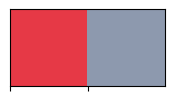

In [3]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

In [4]:
def quick_QC(df, check_cols, min_val, max_val, index_col="participant_id"):
    """Checks for NaNs and out of range outliers """
    
    if index_col in df.columns:
        # check NaNs
        nan_participants = df[df[check_cols].isna().any(axis=1)][index_col].values
        n_nans = len(nan_participants)

        # check range
        outlier_participants = df[df[check_cols].apply(lambda x: (x < min_val) | (x > max_val)).any(axis=1)][index_col].values
        n_outliers = len(outlier_participants)

        print(f"found {n_nans} NaNs and {n_outliers} outliers")
        return list(nan_participants), list(outlier_participants)
    
    else:
        print(f"Provide an index column")
        return None, None

### manifest

In [5]:
manifest_cols = ["participant_id", "visit", "session"]
nipoppy_df = pd.read_csv(manifest_csv)
nipoppy_df = nipoppy_df[manifest_cols] 
nipoppy_participants = nipoppy_df["participant_id"].unique()
n_nipoppy_participants = len(nipoppy_participants)
print(f"nipoppy participants: {n_nipoppy_participants}")
nipoppy_df.head()

nipoppy participants: 306


,participant_id,visit,session
0,MNI0215,MRI_v1,ses-01
1,PD01145,MRI_v1,ses-01
2,MNI0313,MRI_v1,ses-01
3,MNI0476,MRI_v1,ses-01
4,PD01214,MRI_v1,ses-01


### Diagnosis info
- as confirmed later by the clinicians

In [6]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

all_participants = list(control_participants) + list(PD_participants)

print(f"PD + control: {len(all_participants)}")
print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

PD + control: 271
Control: 69
PD: 202


,participant_id,redcap_event_name,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,"Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",diagnosis_certainty,diagnosis_group_for_analysis,diagnosis_age
0,MNI0028,Baseline (Arm 1: C-OPN),Unsure / Incertain,Uncertain / Incertain,NaN,Is not PD / N'est pas PD,unknown,55.85
1,MNI0056,Baseline (Arm 1: C-OPN),Yes / Oui,Meets exclusion criteria / Rencontre des critè...,0.0,PD in the opinion of the treating neurologist ...,PD,75.28
2,MNI0058,Baseline (Arm 1: C-OPN),Yes / Oui,Uncertain / Incertain,0.0,Meets MDS criteria for probable PD / Répond au...,PD,56.19
3,MNI0068,Baseline (Arm 1: C-OPN),NaN,NaN,0.0,Self-report / Auto-évaluation,PD,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),Yes / Oui,Meets criteria for Parkinson's disease / Répon...,0.0,Meets MDS criteria for established PD / Répond...,PD,46.02


### UKB - DKT - ASEG fields and names
- These change based on 1) ukbb names 2) FS6 and 3) FS7.

In [7]:
### DKT metadata
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "." + DKT_fields_df["roi"]
# DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

CT_rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])
print("-"*50)
print(f"Loading CT DKT map")
print(f"n_CT_rois: {len(CT_rois)}")
print("-"*50)

lh_CT_rois = DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["hemi_roi"]
rh_CT_rois = DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["hemi_roi"]

# hemi specific dict with FS ROI names
lh_CT_roi_dict = dict(zip(lh_CT_rois,CT_rois))
rh_CT_roi_dict = dict(zip(rh_CT_rois,CT_rois))

### ASEG metadata
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)
left_hemi_suffixes = ["Left-","lh","left-"]
right_hemi_suffixes = ["Right-","rh","right-"]

roi_naming_version = FS_version.split(".",1)[0]
print(f"Loading vol ASEG map")
print(f"**roi_naming_version: {roi_naming_version}**")

roi_col = f"FS{roi_naming_version}_roi"
hemi_col = f"FS{roi_naming_version}_hemi"

vol_ROIs = ASEG_fields_df[roi_col].values
print(f"n_vol_ROIs: {len(vol_ROIs)}")
vol_hemis = ASEG_fields_df[hemi_col].values
vol_hemi_counts = ASEG_fields_df[hemi_col].value_counts()
print(f"n_rois per hemi: {vol_hemi_counts}")

lh_vol_rois = list(ASEG_fields_df[ASEG_fields_df[hemi_col].isin(left_hemi_suffixes)][roi_col].values)
rh_vol_rois = list(ASEG_fields_df[ASEG_fields_df[hemi_col].isin(right_hemi_suffixes)][roi_col].values)
global_vol_rois = list(ASEG_fields_df[ASEG_fields_df[hemi_col].isna()][roi_col].dropna().values)


print(f"n_lh_ASEG_rois: {len(lh_vol_rois)}")
print(f"n_rh_ASEG_rois: {len(rh_vol_rois)}")
print(f"n_global_ASEG_rois: {len(global_vol_rois)}")
print("-"*50)

ASEG_fields_df[hemi_col] = ASEG_fields_df[hemi_col].fillna("")
ASEG_fields_df["hemi_roi"] = ASEG_fields_df[hemi_col] + ASEG_fields_df[roi_col] # delimiter is part of the hemi col is present
lh_hemi_ASEG_rois = ASEG_fields_df[ASEG_fields_df[hemi_col].isin(left_hemi_suffixes)]["hemi_roi"]
rh_hemi_ASEG_rois = ASEG_fields_df[ASEG_fields_df[hemi_col].isin(right_hemi_suffixes)]["hemi_roi"]

lh_hemi_ASEG_roi_dict = dict(zip(lh_hemi_ASEG_rois,lh_vol_rois))
rh_hemi_ASEG_roi_dict = dict(zip(rh_hemi_ASEG_rois,rh_vol_rois))

ASEG_fields_df.head()

--------------------------------------------------
Loading CT DKT map
n_CT_rois: 31
--------------------------------------------------
Loading vol ASEG map
**roi_naming_version: 7**
n_vol_ROIs: 67
n_rois per hemi: FS7_hemi
Left-     16
Right-    16
lh         3
rh         3
Name: count, dtype: int64
n_lh_ASEG_rois: 19
n_rh_ASEG_rois: 19
n_global_ASEG_rois: 27
--------------------------------------------------


,Field ID,Description,metric,ukbb_roi,ukbb_hemi,FS6_roi,FS6_hemi,FS7_roi,FS7_hemi,hemi_roi
0,26523.0,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle,NaN,3rd-Ventricle,,3rd-Ventricle
1,26524.0,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle,NaN,4th-Ventricle,,4th-Ventricle
2,26525.0,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle,NaN,5th-Ventricle,,5th-Ventricle
3,26564.0,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Accumbens-area,Left-,Accumbens-area,Left-,Left-Accumbens-area
4,26595.0,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Accumbens-area,Right-,Accumbens-area,Right-,Right-Accumbens-area


### Read DKT data

In [8]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df["participant_id"] = CT_DKT_df["participant_id"].str.split("-", expand=True)[1]

FS_participants = list(CT_DKT_df["participant_id"].unique())
print(f"n_FS_participants: {len(FS_participants)}")

# Check ROI names 
expected_cols = set(DKT_fields_df["hemi_roi"].unique())
data_cols = set(CT_DKT_df.columns)
if len(expected_cols - data_cols) == 0:
    print("all expected CT DKT ROI names are in the dataframe")
else:
    extra_schema_cols = data_cols - expected_cols
    print(f"missing ROI names in the dataframe: {extra_schema_cols}")

unknown_CT_DKT_cols = set(CT_DKT_df.columns) - set(DKT_fields_df["hemi_roi"].values) - set(["participant_id"])
if len(unknown_CT_DKT_cols) > 0:
    print(f"found extra columns in CT DKT: {unknown_CT_DKT_cols}, dropping extra columns...")
    CT_DKT_df = CT_DKT_df.drop(columns=unknown_CT_DKT_cols)

n_FS_participants: 298
all expected CT DKT ROI names are in the dataframe
found extra columns in CT DKT: {'rh.temporalpole'}, dropping extra columns...


### Merge with demographics

In [9]:
## Merge with demographics
startification_col = "diagnosis_group_for_analysis"
demo_cols = ["participant_id", startification_col]
CT_DKT_df = pd.merge(CT_DKT_df,dx_df[demo_cols],on="participant_id",how="left")

participants_per_group = CT_DKT_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants per group: {participants_per_group}")

CT_DKT_df.head()

participants per group: diagnosis_group_for_analysis
PD         202
control     69
unknown     19
Name: participant_id, dtype: int64


,participant_id,lh.caudalanteriorcingulate,lh.caudalmiddlefrontal,lh.cuneus,lh.entorhinal,lh.fusiform,lh.inferiorparietal,lh.inferiortemporal,lh.isthmuscingulate,lh.lateraloccipital,...,rh.precuneus,rh.rostralanteriorcingulate,rh.rostralmiddlefrontal,rh.superiorfrontal,rh.superiorparietal,rh.superiortemporal,rh.supramarginal,rh.transversetemporal,rh.insula,diagnosis_group_for_analysis
0,MNI0028,2.495,2.365,1.781,3.372,2.821,2.232,2.785,2.061,1.949,...,2.375,2.484,2.151,2.448,2.025,2.732,2.305,2.302,2.981,unknown
1,MNI0056,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.100,2.075,...,2.359,2.358,2.111,2.445,2.400,2.595,2.364,1.990,2.586,PD
2,MNI0058,2.597,2.626,1.892,3.349,2.956,2.457,2.774,2.364,2.008,...,2.566,2.584,2.395,2.545,2.352,2.357,2.597,1.975,1.555,PD
3,MNI0068,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.004,2.000,...,2.170,2.698,2.169,2.274,1.964,2.516,2.232,2.130,2.888,PD
4,MNI0079,2.418,2.654,1.875,3.616,2.765,2.504,2.734,2.185,2.291,...,2.506,2.461,2.278,2.647,2.298,2.794,2.668,2.296,3.117,PD


### Split DKT data into left and right hemisphere

In [10]:
save_results = True

lh_CT_DKT_df = CT_DKT_df[list(lh_CT_rois) + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[list(rh_CT_rois) + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_CT_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_CT_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{save_dir}/CT_DKT_df.csv")
    
CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,rostralanteriorcingulate,rostralmiddlefrontal,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,diagnosis_group_for_analysis,hemi
0,2.495,2.365,1.781,3.372,2.821,2.232,2.785,3.230,2.061,1.949,...,2.624,2.217,2.465,1.987,2.747,2.245,2.042,MNI0028,unknown,lh
1,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.612,2.100,2.075,...,2.420,2.181,2.533,2.464,2.466,2.275,2.057,MNI0056,PD,lh
2,2.597,2.626,1.892,3.349,2.956,2.457,2.774,3.116,2.364,2.008,...,2.716,2.462,2.726,2.275,3.036,2.474,2.311,MNI0058,PD,lh
3,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.898,2.004,2.000,...,2.530,2.184,2.344,1.917,2.355,2.089,1.903,MNI0068,PD,lh
4,2.418,2.654,1.875,3.616,2.765,2.504,2.734,3.343,2.185,2.291,...,2.735,2.359,2.672,2.356,2.806,2.534,2.068,MNI0079,PD,lh


### Quick QC before plots

In [11]:
check_cols = lh_CT_roi_dict.values()
min_val = 0
max_val = 10
nan_participants, outlier_participants = quick_QC(CT_DKT_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"removing {len(remove_participants)} participants: {remove_participants}")
CT_DKT_df = CT_DKT_df[~CT_DKT_df["participant_id"].isin(remove_participants)]

found 1 NaNs and 0 outliers
removing 1 participants: ['PD00457']


### Plot DKT

n_participants: 270
participants_per_group: diagnosis_group_for_analysis
PD         201
control     69
Name: participant_id, dtype: int64


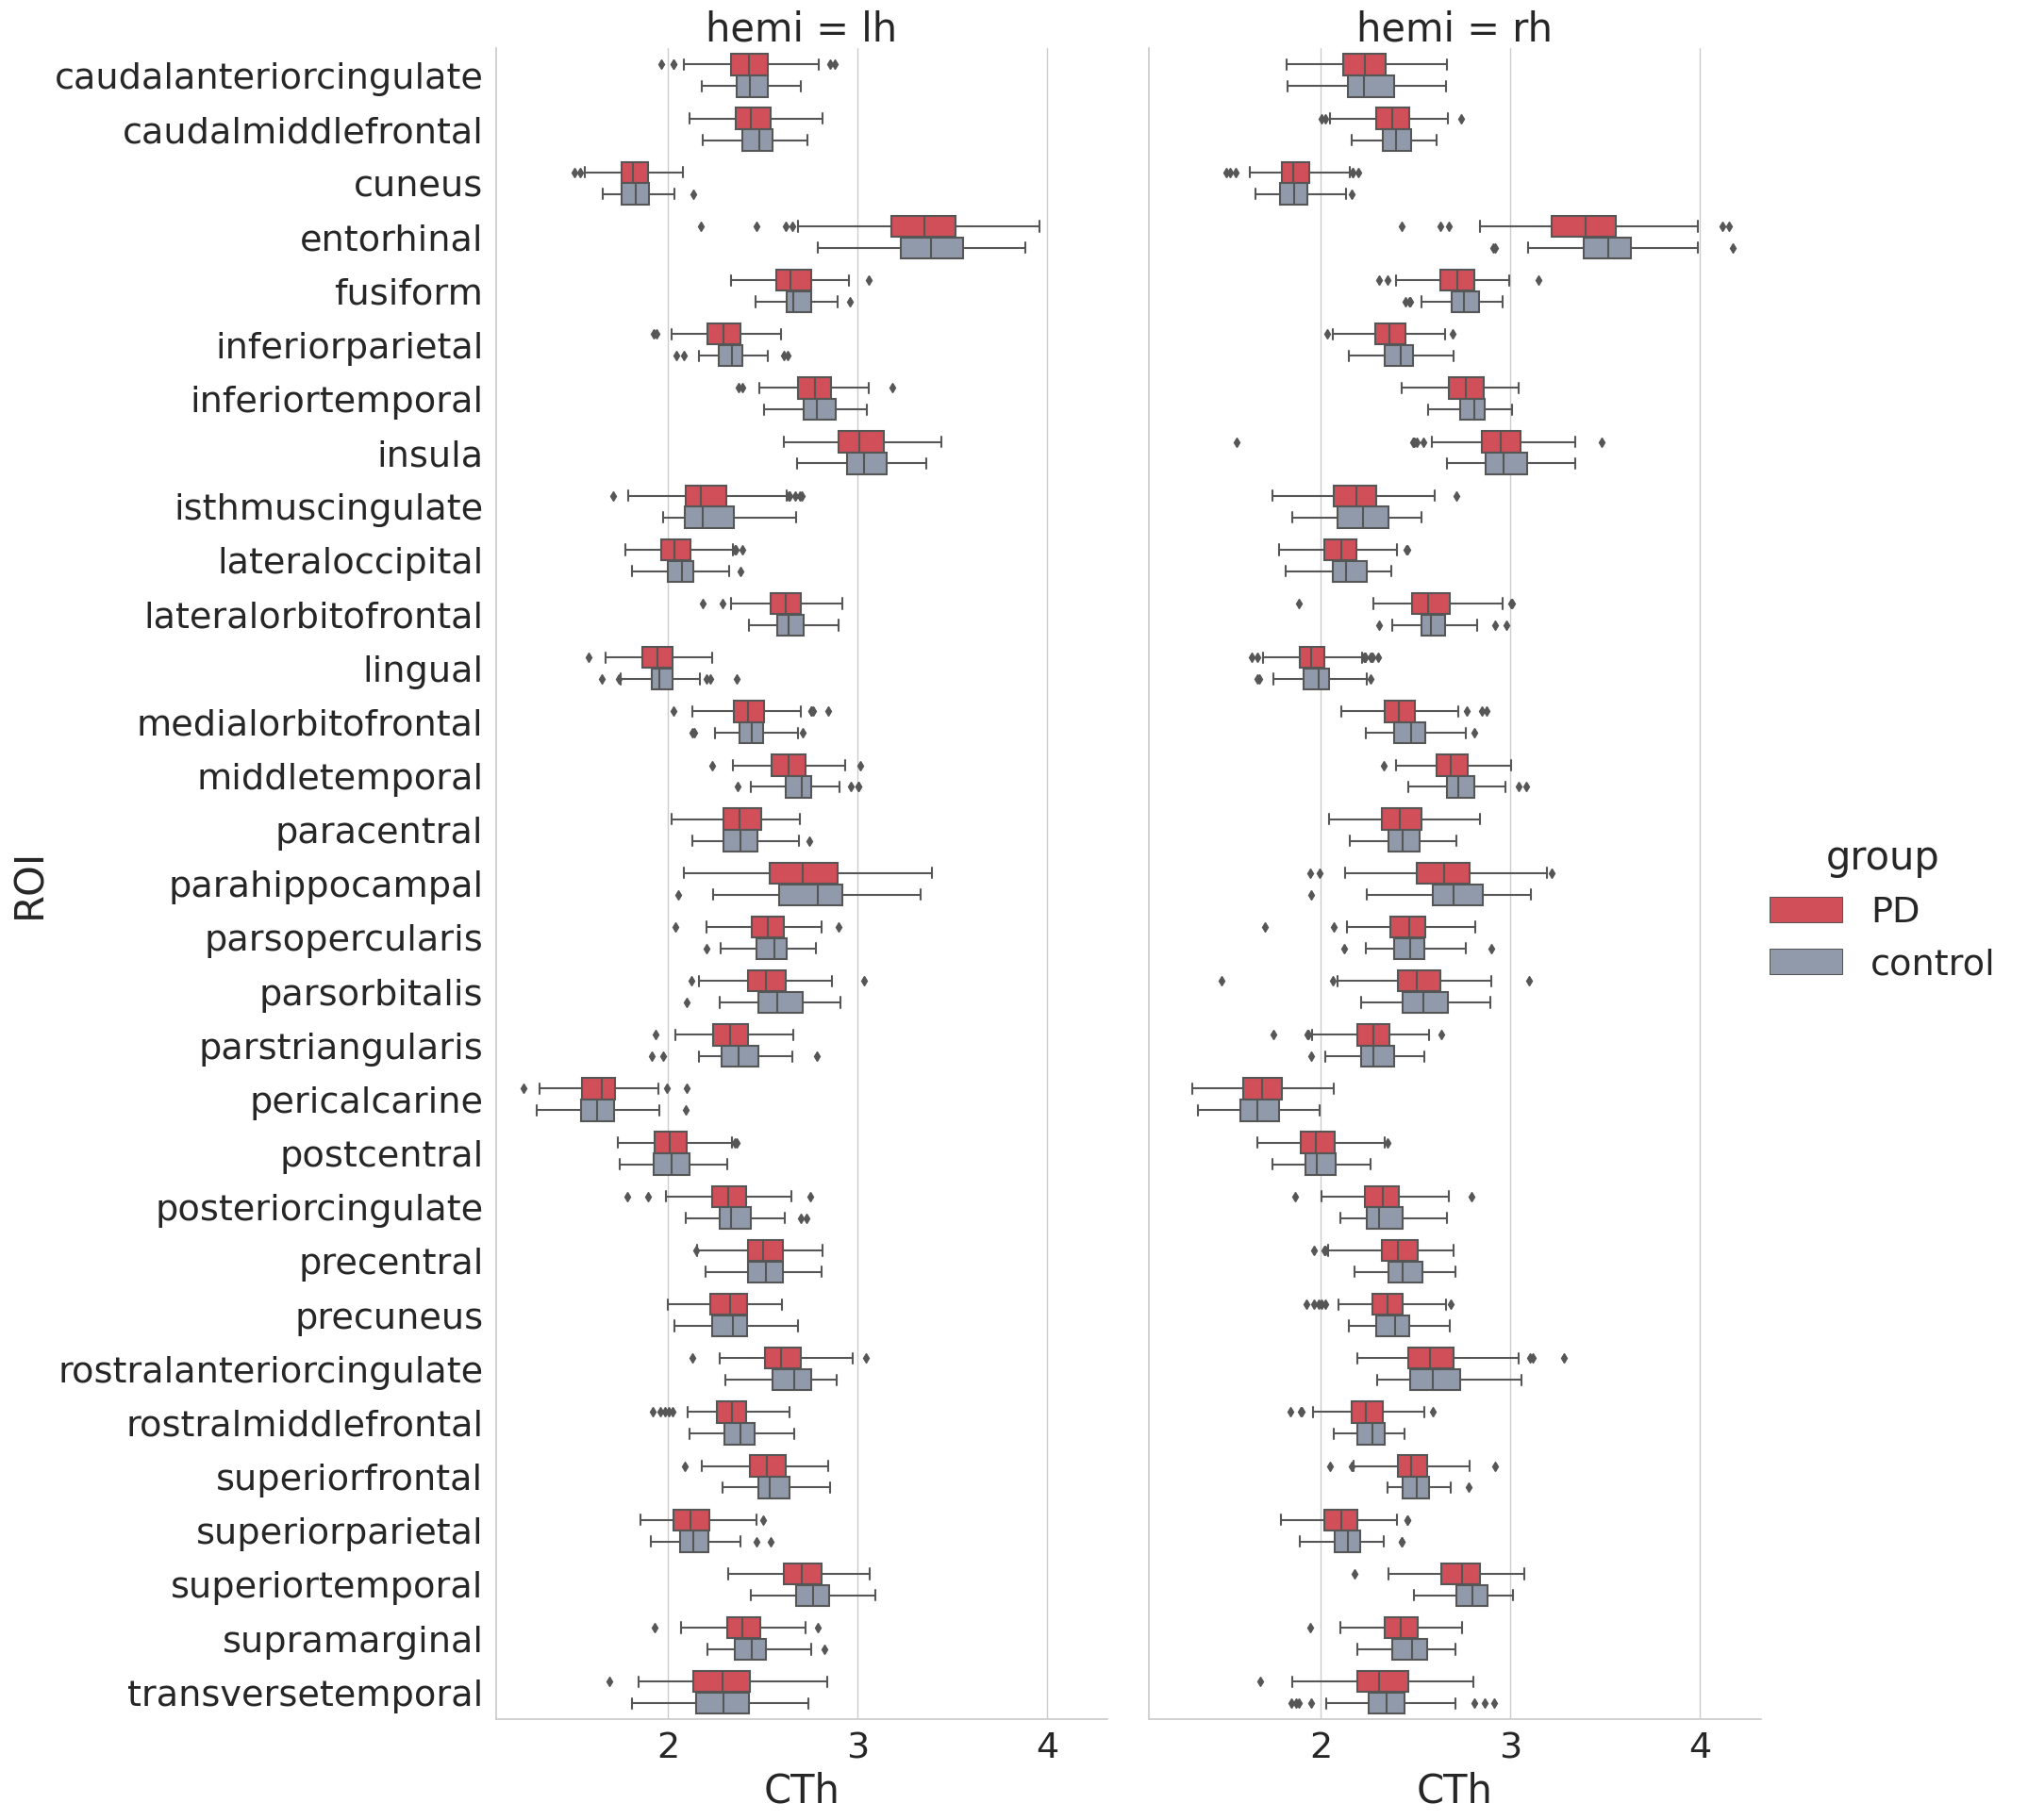

In [12]:
save_fig = True

plot_groups = ["control","PD"]
CT_DKT_df = CT_DKT_df[CT_DKT_df["diagnosis_group_for_analysis"].isin(plot_groups)]

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CTh")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

plot_df["group"] = plot_df["diagnosis_group_for_analysis"] # rename for plotting

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")
participants_per_group = plot_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

sns.set_theme(font_scale=2.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CTh", hue="group", col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Save CT DKT data

In [13]:
save_agg_CT_df = False

if save_agg_CT_df:
    save_file = f"{save_dir}/CT_DKT_df.csv"
    print(f"Saving CT_DKT_df to {save_file}")
    CT_DKT_df.to_csv(save_file, index=False)

CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,rostralanteriorcingulate,rostralmiddlefrontal,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,diagnosis_group_for_analysis,hemi
1,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.612,2.100,2.075,...,2.420,2.181,2.533,2.464,2.466,2.275,2.057,MNI0056,PD,lh
2,2.597,2.626,1.892,3.349,2.956,2.457,2.774,3.116,2.364,2.008,...,2.716,2.462,2.726,2.275,3.036,2.474,2.311,MNI0058,PD,lh
3,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.898,2.004,2.000,...,2.530,2.184,2.344,1.917,2.355,2.089,1.903,MNI0068,PD,lh
4,2.418,2.654,1.875,3.616,2.765,2.504,2.734,3.343,2.185,2.291,...,2.735,2.359,2.672,2.356,2.806,2.534,2.068,MNI0079,PD,lh
5,2.286,2.252,1.925,2.963,2.403,2.191,2.521,2.654,1.908,1.869,...,2.481,2.023,2.209,2.010,2.454,2.117,2.344,MNI0103,PD,lh


### Volumetric measures

In [14]:
vol_ASEG_df = pd.read_csv(ASEG_csv)

vol_ASEG_df["participant_id"] = vol_ASEG_df["participant_id"].str.split("-", expand=True)[1]

FS_participants = list(vol_ASEG_df["participant_id"].unique())
print(f"n_FS_participants: {len(FS_participants)}")

# Check the FS version and corresponding ROI

expected_cols = set(ASEG_fields_df["hemi_roi"].dropna().unique())
data_cols = set(vol_ASEG_df.columns)

if len(expected_cols - data_cols) == 0:
    print("all expected CT DKT ROI names are in the dataframe")
else:
    extra_schema_cols = expected_cols - data_cols
    print(f"missing columns in vol ASEG dataframe: {extra_schema_cols}")


unknown_vol_ASEG_cols = data_cols - expected_cols - set(["participant_id"])
if len(unknown_vol_ASEG_cols) > 0:
    print(f"found extra columns: {unknown_vol_ASEG_cols}")


n_FS_participants: 298
all expected CT DKT ROI names are in the dataframe


### Merge with demographics

In [15]:
## Merge with demographics
startification_col = "diagnosis_group_for_analysis"
demo_cols = ["participant_id", startification_col]
vol_ASEG_df = pd.merge(vol_ASEG_df,dx_df[demo_cols],on="participant_id",how="left")

participants_per_group = vol_ASEG_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants per group: {participants_per_group}")

vol_ASEG_df.head()

participants per group: diagnosis_group_for_analysis
PD         202
control     69
unknown     19
Name: participant_id, dtype: int64


,participant_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,SupraTentorial,SupraTentorialNotVent,Mask,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol,diagnosis_group_for_analysis
0,MNI0028,11538.1,228.9,18843.2,54138.4,7875.5,4029.1,4663.7,2000.3,1360.3,...,1121667.0,1094785.0,1561089.0,0.747035,0.919697,3,4,7,1.697395e+06,unknown
1,MNI0056,30555.6,1607.7,13703.8,48542.0,6155.8,3487.1,4369.6,1823.3,2976.9,...,1126939.0,1036925.0,1599308.0,0.685579,0.876686,15,11,26,1.824266e+06,PD
2,MNI0058,5535.2,414.3,13783.8,49483.3,8159.6,3600.7,5053.6,2039.0,1429.2,...,1108806.0,1091974.0,1603655.0,0.757695,0.971572,9,35,44,1.650578e+06,PD
3,MNI0068,10275.8,938.8,12266.4,54126.8,6451.4,3012.0,3665.1,1439.1,1348.8,...,932678.0,907166.0,1371644.0,0.709501,0.915154,6,5,11,1.498812e+06,PD
4,MNI0079,4671.2,214.3,16150.4,53101.7,7972.0,3534.6,4085.1,1915.6,952.4,...,1007099.0,994020.0,1447415.0,0.744766,0.941479,6,9,15,1.537383e+06,PD


### Split bilateral volumetric data into left and right hemisphere

In [16]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[list(lh_hemi_ASEG_rois) + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[list(rh_hemi_ASEG_rois) + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_vol_rois + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_hemi_ASEG_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_hemi_ASEG_roi_dict)
# global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_roi_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{save_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{save_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

,Accumbens-area,Amygdala,Caudate,Cerebellum-Cortex,Cerebellum-White-Matter,CerebralWhiteMatter,Cortex,Hippocampus,Inf-Lat-Vent,Lateral-Ventricle,...,Thalamus,VentralDC,choroid-plexus,vessel,SurfaceHoles,WM-hypointensities,non-WM-hypointensities,participant_id,diagnosis_group_for_analysis,hemi
0,579.6,1668.4,4029.1,54138.4,18843.2,283456.5,234057.247054,3934.9,228.9,11538.1,...,7875.5,4452.1,677.5,55.8,3,0.0,0.0,MNI0028,unknown,lh
1,263.9,1592.1,3487.1,48542.0,13703.8,255251.5,232637.328935,3730.1,1607.7,30555.6,...,6155.8,3841.0,974.1,48.7,15,0.0,0.0,MNI0056,PD,lh
2,711.8,1827.6,3600.7,49483.3,13783.8,273383.5,266523.290741,5074.8,414.3,5535.2,...,8159.6,4251.3,567.4,14.4,9,0.0,0.0,MNI0058,PD,lh
3,562.6,1818.5,3012.0,54126.8,12266.4,218817.5,210987.112993,3842.7,938.8,10275.8,...,6451.4,3567.8,572.8,9.4,6,0.0,0.0,MNI0068,PD,lh
4,567.5,1609.3,3534.6,53101.7,16150.4,236617.0,230780.196816,4146.3,214.3,4671.2,...,7972.0,4035.0,272.5,108.8,6,0.0,0.0,MNI0079,PD,lh


### Quick QC before plots

In [17]:
check_cols = lh_hemi_ASEG_roi_dict.values()
min_val = 0
max_val = 3000000
nan_participants, outlier_participants = quick_QC(bilateral_vol_ASEG_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"Bilateral regions: removing {len(remove_participants)} participants")
bilateral_vol_ASEG_df = bilateral_vol_ASEG_df[~bilateral_vol_ASEG_df["participant_id"].isin(remove_participants)]

check_cols = global_vol_rois
nan_participants, outlier_participants = quick_QC(global_vol_ASEG_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"Global regions: removing {len(remove_participants)} participants")
global_vol_ASEG_df = global_vol_ASEG_df[~global_vol_ASEG_df["participant_id"].isin(remove_participants)]

found 0 NaNs and 0 outliers
Bilateral regions: removing 0 participants
found 0 NaNs and 0 outliers
Global regions: removing 0 participants


### Plot ASEG
- hemi 
- global

n_participants: 271
participants_per_group: diagnosis_group_for_analysis
PD         202
control     69
Name: participant_id, dtype: int64


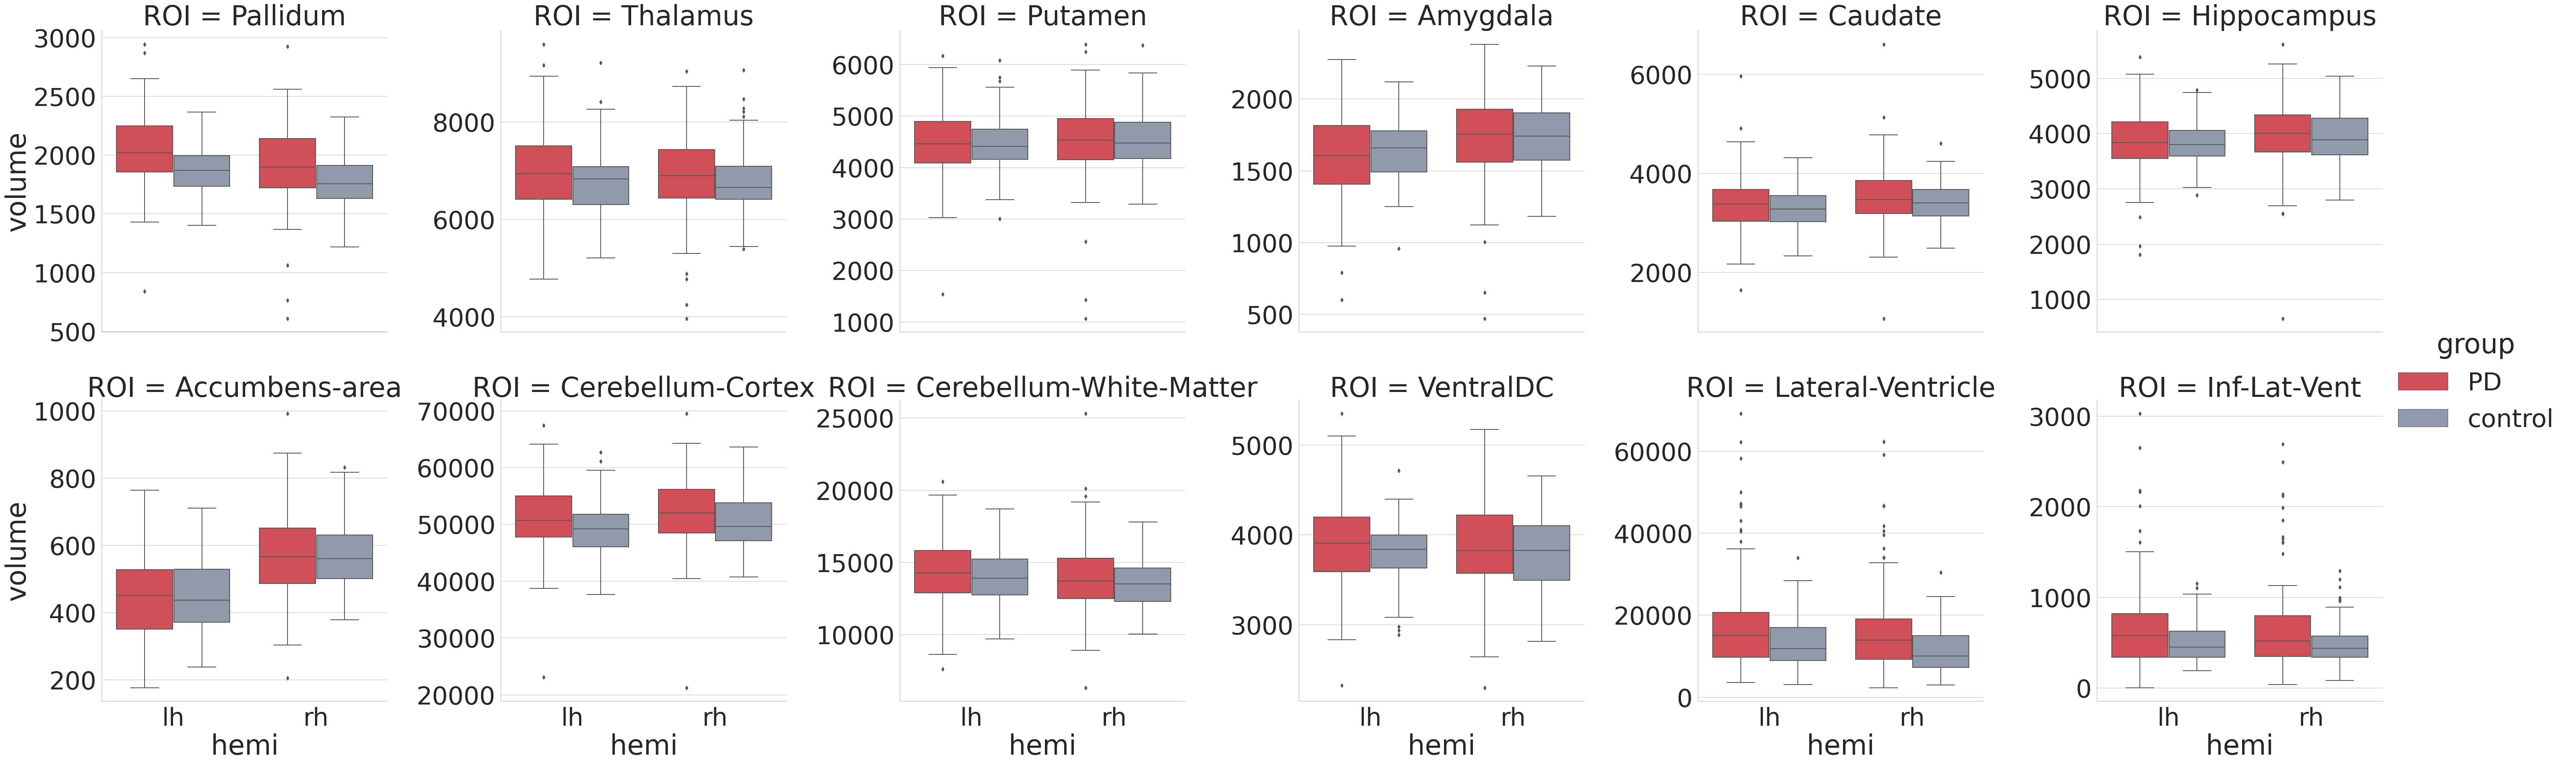

In [18]:
save_fig = True

# Rename global regions for brevity
plot_renaming_dict = {"Thalamus-Proper":"Thalamus"} #FSv6 --> FSv7
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=plot_renaming_dict)

plot_groups = ["control","PD"]
bilateral_vol_ASEG_df = bilateral_vol_ASEG_df[bilateral_vol_ASEG_df["diagnosis_group_for_analysis"].isin(plot_groups)]

vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")
participants_per_group = plot_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

plot_df["group"] = plot_df["diagnosis_group_for_analysis"] # rename for plotting

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_bilateral.png")

### Save hemi aseg vols

In [19]:
save_agg_aseg_df = False

if save_agg_aseg_df:
    save_file = f"{save_dir}/bilateral_vol_ASEG_df.csv"
    print(f"Saving aseg_DKT_df to {save_file}")
    bilateral_vol_ASEG_df.to_csv(save_file, index=False)

bilateral_vol_ASEG_df.head()

,Accumbens-area,Amygdala,Caudate,Cerebellum-Cortex,Cerebellum-White-Matter,CerebralWhiteMatter,Cortex,Hippocampus,Inf-Lat-Vent,Lateral-Ventricle,...,Thalamus,VentralDC,choroid-plexus,vessel,SurfaceHoles,WM-hypointensities,non-WM-hypointensities,participant_id,diagnosis_group_for_analysis,hemi
1,263.9,1592.1,3487.1,48542.0,13703.8,255251.5,232637.328935,3730.1,1607.7,30555.6,...,6155.8,3841.0,974.1,48.7,15,0.0,0.0,MNI0056,PD,lh
2,711.8,1827.6,3600.7,49483.3,13783.8,273383.5,266523.290741,5074.8,414.3,5535.2,...,8159.6,4251.3,567.4,14.4,9,0.0,0.0,MNI0058,PD,lh
3,562.6,1818.5,3012.0,54126.8,12266.4,218817.5,210987.112993,3842.7,938.8,10275.8,...,6451.4,3567.8,572.8,9.4,6,0.0,0.0,MNI0068,PD,lh
4,567.5,1609.3,3534.6,53101.7,16150.4,236617.0,230780.196816,4146.3,214.3,4671.2,...,7972.0,4035.0,272.5,108.8,6,0.0,0.0,MNI0079,PD,lh
5,328.9,1043.7,3693.2,51639.9,12212.0,239245.0,216712.780975,3692.5,1239.8,23099.9,...,6270.2,4036.7,965.9,18.9,46,0.0,0.0,MNI0103,PD,lh


n_participants: 271
participants_per_group: diagnosis_group_for_analysis
PD         202
control     69
Name: participant_id, dtype: int64


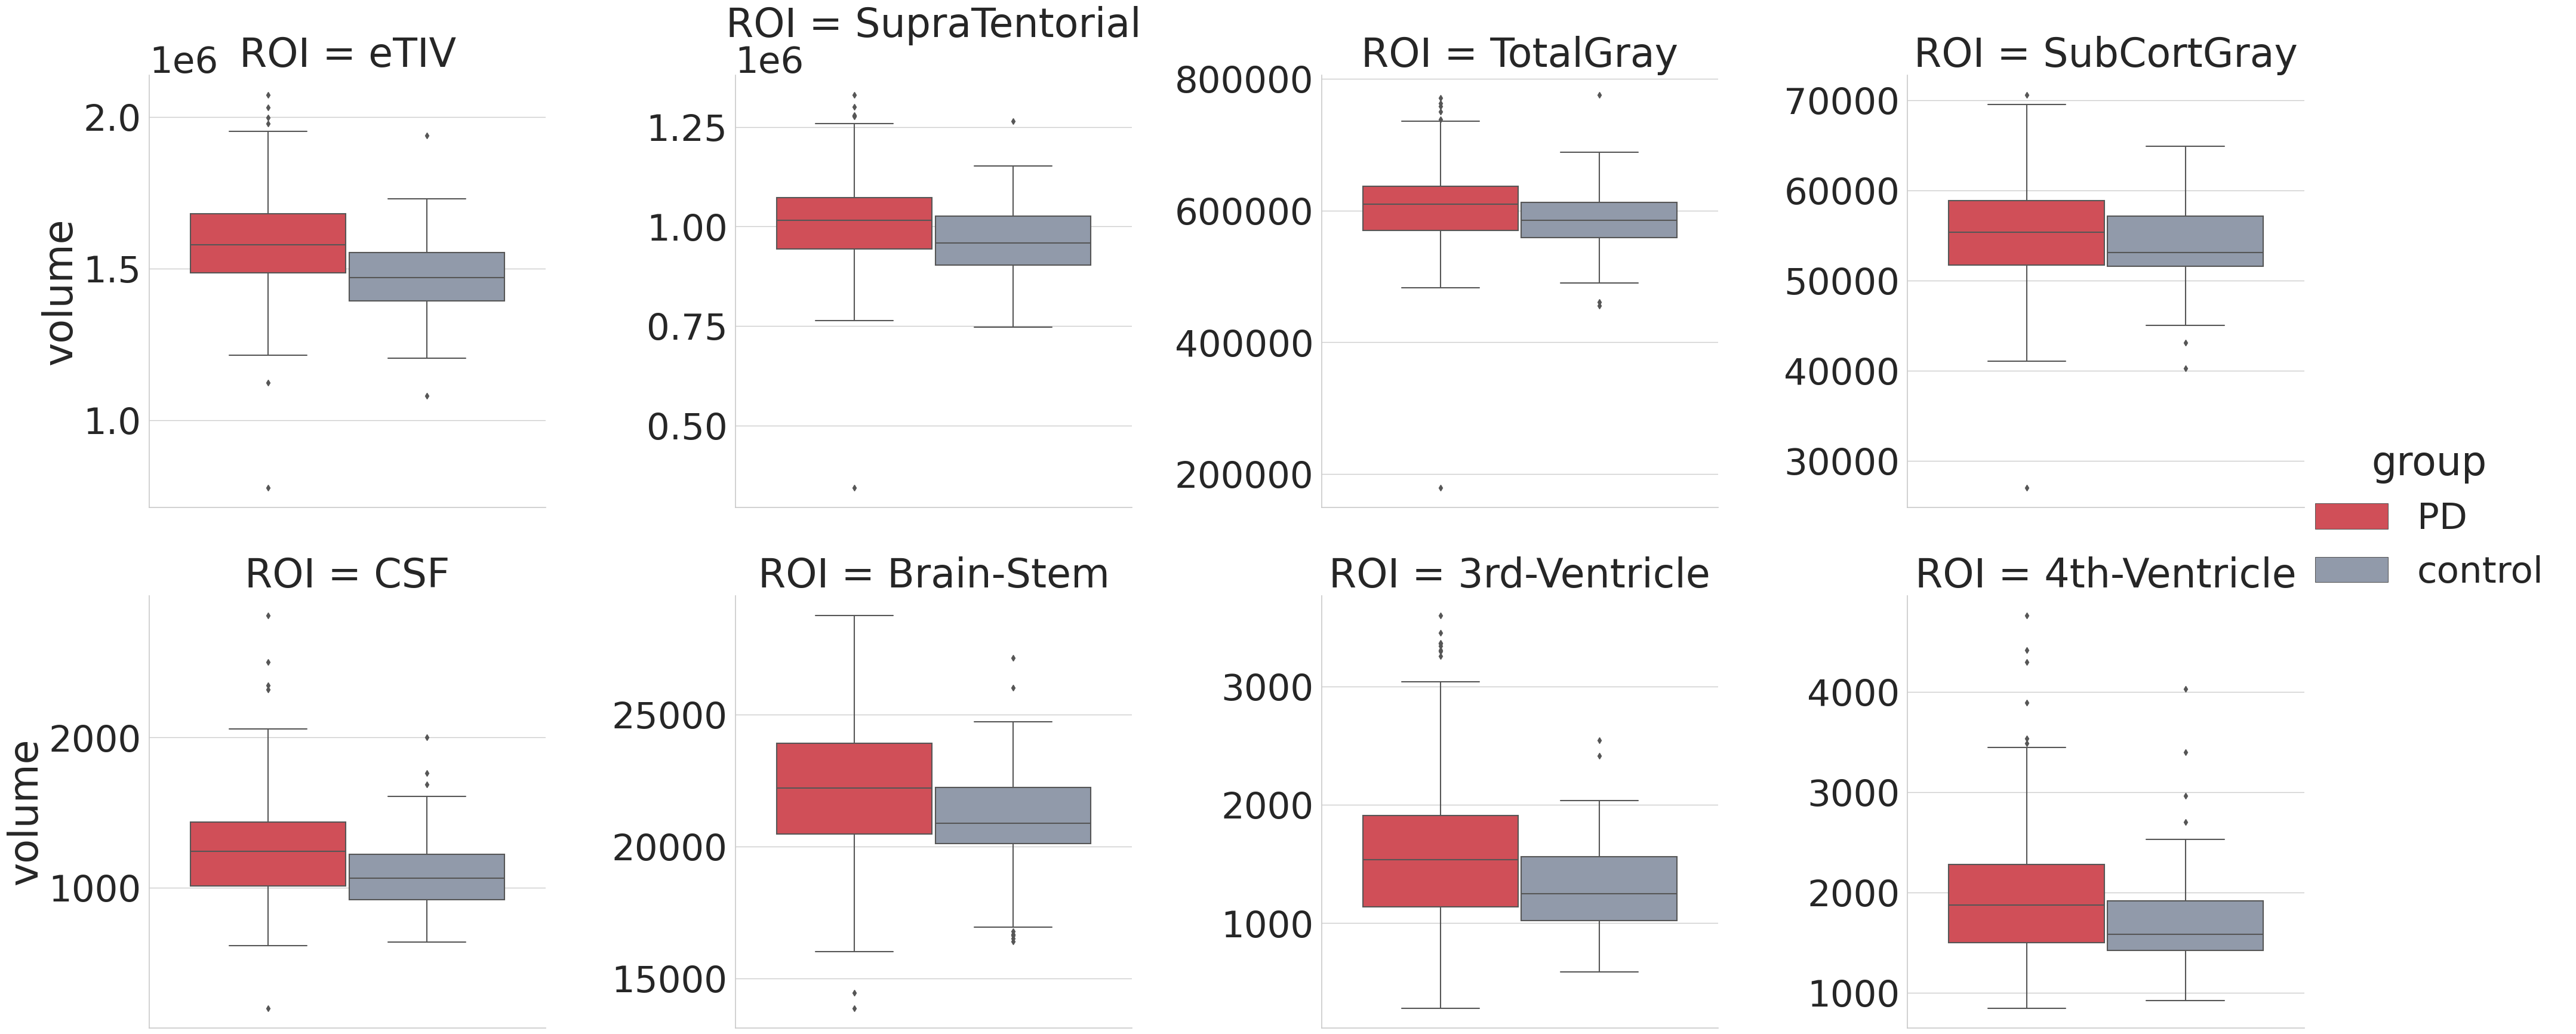

In [20]:
save_fig = True

# Rename global regions for brevity
plot_renaming_dict = {"EstimatedTotalIntraCranialVol":"eTIV"}
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=plot_renaming_dict)

plot_groups = ["control","PD"]
global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["diagnosis_group_for_analysis"].isin(plot_groups)]


global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")
participants_per_group = plot_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

plot_df["group"] = plot_df["diagnosis_group_for_analysis"] # rename for plotting


sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    g.set_xlabels("")
    g.set_xticklabels("")

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Save global aseg vols

In [21]:
save_agg_aseg_df = False

if save_agg_aseg_df:
    save_file = f"{save_dir}/global_vol_ASEG_df.csv"
    print(f"Saving aseg_DKT_df to {save_file}")
    global_vol_ASEG_df.to_csv(save_file, index=False)

global_vol_ASEG_df.head()

,3rd-Ventricle,4th-Ventricle,5th-Ventricle,Brain-Stem,BrainSeg,BrainSegNotVent,CC_Anterior,CC_Central,CC_Mid_Anterior,CC_Mid_Posterior,...,non-WM-hypointensities,Cortex,CerebralWhiteMatter,Mask,MaskVol-to-eTIV,BrainSegVol-to-eTIV,SurfaceHoles,participant_id,diagnosis_group_for_analysis,hemi
1,2976.9,2691.0,0.0,20471.7,1250678.0,1160664.0,1011.1,445.4,491.8,466.4,...,0.0,468121.412514,515939.0,1599308.0,0.876686,0.685579,26,MNI0056,PD,global
2,1429.2,988.4,0.0,27453.5,1250635.0,1233803.0,768.3,756.6,578.4,523.3,...,0.0,491792.631716,549767.0,1603655.0,0.971572,0.757695,44,MNI0058,PD,global
3,1348.8,1599.4,0.0,20654.2,1063409.0,1037897.0,854.4,420.8,705.6,486.9,...,0.0,422490.746237,434460.0,1371644.0,0.915154,0.709501,11,MNI0068,PD,global
4,952.4,1449.5,0.0,21743.1,1144991.0,1131912.0,930.8,801.1,797.4,507.2,...,0.0,462559.995060,474975.0,1447415.0,0.941479,0.744766,15,MNI0079,PD,global
5,3342.1,2051.8,0.0,24225.2,1145589.0,1088497.0,810.0,347.2,340.4,473.4,...,0.0,435999.292421,471155.0,1575747.0,0.958491,0.696836,108,MNI0103,PD,global


### Make enigma-plots

In [31]:
from enigmatoolbox.plotting import plot_subcortical
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

In [23]:
enigma_rois = [
    'Left-Lateral-Ventricle', 'Left-Thalamus', 'Left-Caudate', 
    'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala', 
    'Left-Accumbens-area', 'Right-Lateral-Ventricle', 'Right-Thalamus', 
    'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 
    'Right-Amygdala', 'Right-Accumbens-area'
]

global_vol_roi  = 'EstimatedTotalIntraCranialVol'

print("-"*50)
print(f"n_enigma_rois: {len(enigma_rois)}, global_vol_roi: {global_vol_roi}")
print("-"*50)

# for plotting purposes
enigma_order = [7, 6, 2, 5, 4, 3, 1, 0, 15, 14, 10, 13, 12, 11, 9, 8]

demo_cols = ["participant_id", "diagnosis_group_for_analysis"]

enigma_vol_df = vol_ASEG_df[demo_cols + enigma_rois + [global_vol_roi]]

plot_groups = ["control","PD"]
enigma_vol_df = enigma_vol_df[enigma_vol_df["diagnosis_group_for_analysis"].isin(plot_groups)]

# Sanity checks
enigma_vol_df_control = enigma_vol_df[enigma_vol_df["diagnosis_group_for_analysis"] == "control"]
enigma_vol_df_PD = enigma_vol_df[enigma_vol_df["diagnosis_group_for_analysis"] == "PD"]

PD_avg_vol = enigma_vol_df_PD[enigma_rois].mean().values[enigma_order]
control_avg_vol = enigma_vol_df_control[enigma_rois].mean().values[enigma_order]

print(f"PD_avg_vol: {PD_avg_vol}")
print(f"control_avg_vol: {control_avg_vol}")


--------------------------------------------------
n_enigma_rois: 16, global_vol_roi: EstimatedTotalIntraCranialVol
--------------------------------------------------
PD_avg_vol: [  444.18811881  1594.91287129  3380.16386139  3859.49108911
  2031.93168317  4486.92029703  6990.8049505  16990.76336634
   568.77277228  1730.91782178  3524.64257426  3986.2480198
  1917.44950495  4522.29059406  6903.51386139 15427.92821782]
control_avg_vol: [  446.89275362  1634.56376812  3318.65362319  3799.92898551
  1869.63333333  4461.29855072  6805.43768116 13336.69275362
   571.34057971  1728.52318841  3404.49710145  3968.
  1772.76086957  4528.91014493  6764.12753623 11632.57681159]


### get demographics for analysis

In [24]:
demo_df = pd.read_csv(demographics_csv)
demo_df = demo_df[demo_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

demo_cols = ["participant_id", "sex"]
demo_df = demo_df[demo_cols]

mri_sessions_df = pd.read_csv(mri_sessions_csv)
mri_sessions_df = mri_sessions_df[mri_sessions_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]


demo_df = pd.merge(demo_df, mri_sessions_df, on="participant_id", how="left")

demo_df.head()

,participant_id,sex,redcap_event_name,session,MRI_age
0,MNI0028,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,60.19
1,MNI0056,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,79.24
2,MNI0058,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,57.43
3,MNI0068,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,69.30
4,MNI0079,Female/Féminin,Baseline (Arm 1: C-OPN),ses-01,50.08


In [83]:
normalized_enigma_vol_df = enigma_vol_df.copy()
# normalized_enigma_vol_df[enigma_rois] = enigma_vol_df[enigma_rois].div(enigma_vol_df[global_vol_roi], axis=0) * 100 

normalized_enigma_vol_df = pd.merge(normalized_enigma_vol_df, demo_df, on="participant_id", how="left")
normalized_enigma_vol_df = normalized_enigma_vol_df.rename(columns={"diagnosis_group_for_analysis":"group", "MRI_age":"age"})

save_dir = "/home/nikhil/projects/Parkinsons/qpn//results/ses-01/anat/dfs/"
normalized_enigma_vol_df.to_csv(f"{save_dir}/normalized_enigma_vol_df.csv", index=False)
normalized_enigma_vol_df.head()

,participant_id,group,Left-Lateral-Ventricle,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,EstimatedTotalIntraCranialVol,sex,redcap_event_name,session,age
0,MNI0056,PD,30555.6,6155.8,3487.1,4369.6,1823.3,3730.1,1592.1,263.9,...,4709.1,2107.8,3702.9,1795.8,383.2,1.824266e+06,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,79.24
1,MNI0058,PD,5535.2,8159.6,3600.7,5053.6,2039.0,5074.8,1827.6,711.8,...,1422.1,761.2,2689.0,651.6,302.9,1.650578e+06,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,57.43
2,MNI0068,PD,10275.8,6451.4,3012.0,3665.1,1439.1,3842.7,1818.5,562.6,...,4369.5,1509.2,3788.2,1931.9,582.8,1.498812e+06,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,69.30
3,MNI0079,PD,4671.2,7972.0,3534.6,4085.1,1915.6,4146.3,1609.3,567.5,...,4099.7,1875.0,4380.1,1806.2,591.3,1.537383e+06,Female/Féminin,Baseline (Arm 1: C-OPN),ses-01,50.08
4,MNI0103,PD,23099.9,6270.2,3693.2,4981.8,2648.6,3692.5,1043.7,328.9,...,3320.6,2259.0,3445.8,1156.3,496.9,1.643987e+06,Male/Masculin,Baseline (Arm 1: C-OPN),ses-01,82.23


In [86]:
stats_df = normalized_enigma_vol_df.copy()

betas = pd.DataFrame(index=['const', 'group', 'age', 'sex', 'ICV'], columns=enigma_rois)
dvals = pd.DataFrame(index=['const', 'group', 'age', 'sex', 'ICV'], columns=enigma_rois)
pvals = pd.DataFrame(index=['const', 'group', 'age', 'sex', 'ICV'], columns=enigma_rois)
for roi in enigma_rois:
    new_roi = roi.replace("-","")
    # print(f"running model for {roi}-->{new_roi}")
    stats_df = stats_df.rename(columns={roi:new_roi})
    model = smf.ols(formula=f"{new_roi} ~ age + C(group, Treatment(reference='control')) + C(sex) + EstimatedTotalIntraCranialVol", data=stats_df).fit()
    betas[roi] = model.params.values
    dvals[roi] = model.params[1]/np.std(model.resid, ddof=1)
    pvals[roi] = model.pvalues.values

# reorder results based on enigma order of ROIs
b = betas.loc['group'][enigma_order]
d = dvals.loc['group'][enigma_order]
p = multipletests(pvals.loc['group'], method='fdr_bh')[1][enigma_order]

d_thresholded = d.where(p < 0.05, other=pd.NA)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     RightAccumbensarea   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     42.07
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.56e-27
Time:                        22:19:08   Log-Likelihood:                -1620.0
No. Observations:                 271   AIC:                             3250.
Df Residuals:                     266   BIC:                             3268.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        517.6220     71.686      7.221      0.000     376.477     658.767
C(group, Treatment(reference='control'))[T.PD]    -9.5095     14.259     -0.667      0.505     -37.584      18.565
C(sex)[T.Male/Masculin]                          -30.1252     14.249     -2.114      0.035     -58.180      -2.071
age                                               -6.1586      0.599    -10.278      0.000      -7.338      -4.979
EstimatedTotalIntraCranialVol                      0.0003   4.13e-05      7.383      0.000       0.000       0.000
==============================================================================
Omnibus:                        1.180   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.554   Jarque-Bera (JB):                0.898
Skew:                          -0.058   Prob(JB):                        0.638
Kurtosis:                       3.257   Cond. No.                     1.93e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
# visualize results
min_color = -np.abs(d_thresholded.max().round(2))
max_color = np.abs(d_thresholded.max().round(2))
save_file = f"{figs_dir}/enigma_vols_effect_size.png"
print(f"min_color: {min_color}, max_color: {max_color}")
print(f"save_file: {save_file}")
plot_subcortical(array_name=d_thresholded, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                    interactive=False, share='both', color_range=(min_color, max_color), 
                    nan_color=(255, 255, 255, 1), cmap="coolwarm", transparent_bg=True,
                    screenshot=True, filename=save_file)

min_color: -0.39, max_color: 0.39
save_file: /home/nikhil/projects/Parkinsons/qpn//results/ses-01/anat/figs//enigma_vols_effect_size.png


'/home/nikhil/projects/Parkinsons/qpn/results/ses-01/anat/figs/enigma_vols_effect_size.png'

In [34]:

# run linear model
# covs = normalized_enigma_vol_df[['group', 'age', 'sex']].copy()
# betas = pd.DataFrame(index=['const', 'group', 'age', 'sex'], columns=enigma_rois)
# dvals = pd.DataFrame(index=['const', 'group', 'age', 'sex'], columns=enigma_rois)
# pvals = pd.DataFrame(index=['const', 'group', 'age', 'sex'], columns=enigma_rois)

# for roi in enigma_rois:
#     X = pd.concat([pd.get_dummies(covs['group'], drop_first=True), covs['age'],
#                        pd.get_dummies(covs['sex'], drop_first=True)], axis=1)
#     X = sm.add_constant(X)
#     model = sm.OLS(normalized_enigma_vol_df[roi], X.astype(float)).fit()
#     betas[roi] = model.params.values
#     dvals[roi] = model.params[1]/np.std(model.resid, ddof=1)
#     pvals[roi] = model.pvalues.values

# # reorder results based on enigma order of ROIs
# b = betas.loc['group'][enigma_order]
# d = dvals.loc['group'][enigma_order]
# p = multipletests(pvals.loc['group'], method='fdr_bh')[1][enigma_order]

# d_thresholded = d.where(p < 0.05, other=pd.NA)
# min_color = -d_thresholded.max().round(2)
# max_color = d_thresholded.max().round(2)

# visualize results
# save_file = f"{figs_dir}/enigma_vols_effect_size.png"
# plot_subcortical(array_name=d_thresholded, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
#                     interactive=False, share='both', color_range=(min_color, max_color), 
#                     nan_color=(255, 255, 255, 1), cmap="inferno", transparent_bg=True,
#                     screenshot=True, filename=save_file)
